<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, pcmdpy as ppy
from astropy.io import fits
import pickle


import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from photutils.isophote import EllipseGeometry, Ellipse
from photutils import EllipticalAperture
from photutils.isophote import build_ellipse_model
from photutils.isophote import EllipseSample, Isophote, IsophoteList
from photutils.isophote.isophote import Isophote, IsophoteList
import pyregion
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

GPU acceleration not available, sorry
No module named 'pycuda'


In [2]:
plt.style.use('seaborn-poster')

In [3]:
f = ppy.instrument.default_m49_filters()

In [4]:
iso_model = ppy.isochrones.Isochrone_Model(f, dm_interp=-1)

In [5]:
id_map = fits.open('../data/m49_isophot_ids.fits')['IDS'].data

In [6]:
im_shape = id_map.shape

In [7]:
m49_data = ppy.utils.DataSet(['../data/hst_9401_01_acs_wfc_f850lp_drz.fits', '../data/hst_9401_01_acs_wfc_f475w_drz.fits'],
                            ppy.instrument.m49_filter_sets)

In [8]:
with fits.open('../data/hst_9401_01_acs_wfc_f850lp_drz.fits') as hdu:
    im_F850LP = hdu['SCI'].data * f[0]._exposure
    mask_F850LP = (hdu['WHT'].data <= 0.)
    header_F850LP = hdu['PRIMARY'].header

In [9]:
with fits.open('../data/hst_9401_01_acs_wfc_f475w_drz.fits') as hdu:
    im_F475W = hdu['SCI'].data * f[1]._exposure
    mask_F475W = (hdu['WHT'].data <= 0.)
    header_F475W = hdu['PRIMARY'].header

In [10]:
mask = mask_F850LP + mask_F475W
mask += (im_F475W <= 0.)
mask += (im_F850LP <= 0.)
star_cutout = pyregion.open('../data/star_large.reg').as_imagecoord(header=header_F850LP).get_mask(shape=im_shape)
mask += star_cutout

In [11]:
results = np.loadtxt('../data/hst_9401_01_acs_wfc_f475w_daophot_trm.cat', unpack=True)
x1 = results[0]
y1 = results[1]

In [12]:
results = np.loadtxt('../data/hst_9401_01_acs_wfc_f850lp_daophot_trm.cat', unpack=True)
x2 = results[0]
y2 = results[1]

In [13]:
def get_cutout(r):
    cutout = np.zeros((21,21)).astype(bool)
    for i in range(-r, r+1):
        for j in range(-r, r+1):
            if np.sqrt(i**2 + j**2) <= r:
                cutout[10+i,10+j] = True
    return cutout

def cutout_sources(xs, ys, r=10):
    manual_mask = np.zeros(im_shape).astype(bool)
    cutout = get_cutout(r)
    for x, y in tqdm(zip(xs, ys)):
        x_ = int(np.round(x))
        y_ = int(np.round(y))
        manual_mask[y_-10:y_+11, x_-10:x_+11] = cutout
    return manual_mask

In [14]:
dao_mask = cutout_sources(x1, y1, r=10) + cutout_sources(x2, y2, r=10)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [15]:
manual_mask = pyregion.open('../data/m49_manual_sources.reg').as_imagecoord(header=header_F850LP).get_mask(shape=im_shape)

In [16]:
id_map[dao_mask] = -2
id_map[manual_mask] = -3

In [17]:
c_max = np.max(id_map)

In [18]:
isolist_F850LP = pickle.load(open("../data/isolist_F850LP.p", 'rb'))

In [19]:
isolist_F475W = pickle.load(open("../data/isolist_F475W.p", 'rb'))

In [20]:
mags_z = f[0].counts_to_mag(isolist_F850LP.intens)
mags_g = f[1].counts_to_mag(isolist_F475W.intens)

In [21]:
Neff = [np.sqrt(np.sum(id_map == i)) for i in range(1, c_max+1)]

In [22]:
Neff_min = 400
Neff_max = 1000
mag_tol = 0.2

In [23]:
pcmd_regions = {}
flags = {}
temp_region = []
temp_mags = []
temp_counts = []
k = 1
for i in range(1, c_max+1):
    temp_region += [i]
    temp_mags += [mags_z[i-1]]
    temp_counts += [Neff[i-1]]
    if np.sum(temp_counts) < Neff_min:
        continue
    elif np.sum(temp_counts) > Neff_max:
        if len(temp_region) == 1:
            pcmd_regions[k] = temp_region
            flags[k] = 'L'
            k += 1
            temp_region = []
            temp_mags = []
            temp_counts = []
            continue
        else:
            pcmd_regions[k] = temp_region[:-1]
            flags[k] = 'W'
            k += 1
            temp_region = [i]
            temp_mags = [mags_z[i-1]]
            temp_counts += [Neff[i-1]]
    else:
        pcmd_regions[k] = temp_region
        if (max(temp_mags) - min(temp_mags) > mag_tol):
            flags[k] = max(temp_mags) - min(temp_mags)
        else:
            flags[k] = 0
        k += 1
        temp_region = []
        temp_mags = []
        temp_counts = []

In [24]:
Neffs = {}
ids_final = np.copy(id_map)
for k in pcmd_regions.keys():
    Neffs[k] = 0.
    for i in pcmd_regions[k]:
        Neffs[k] += Neff[i-1]
        ids_final[(id_map == i)] = k

In [25]:
k_max = max(pcmd_regions.keys())
print('{:d} Regions'.format(k_max))

25 Regions


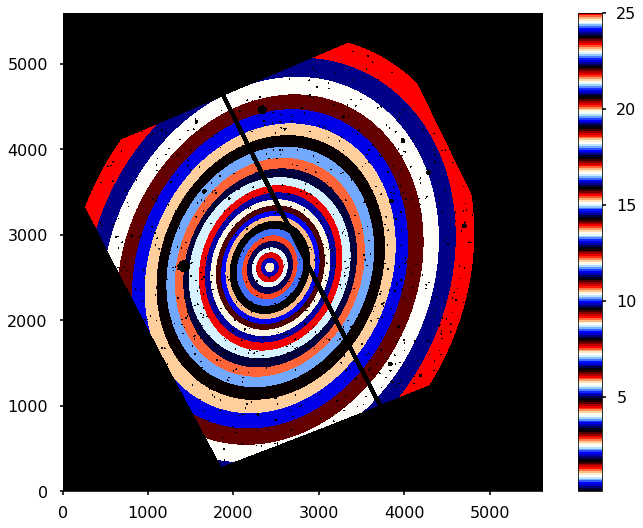

In [26]:
plt.imshow(ids_final, cmap='flag_r', origin='lower', vmin=0.1)
plt.colorbar()

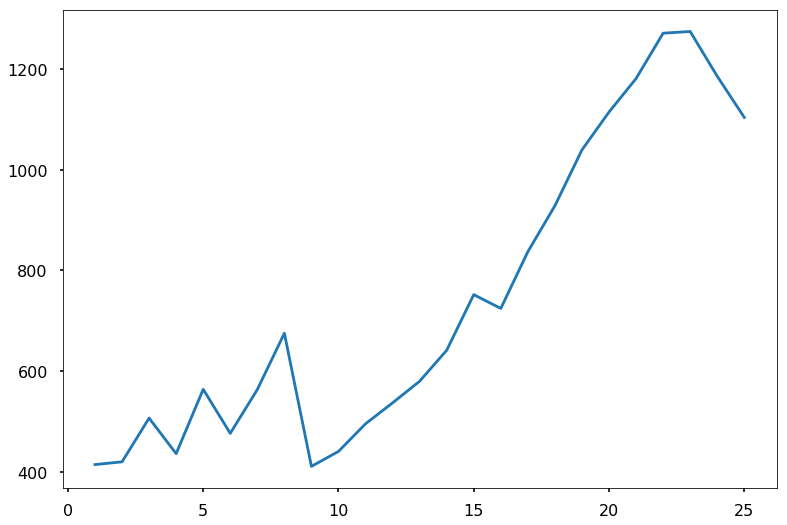

In [27]:
plt.plot(Neffs.keys(),Neffs.values())

In [28]:
def make_rgb_image(image):
    new_image = np.zeros((image.shape[0], image.shape[1], 3))
    new_image[:,:,0] = image[:,:,0]
    new_image[:,:,2] = image[:,:,1]
    new_image[:,:,1] = 0.5*(image[:,:,0] + image[:,:,1])
    return new_image

In [29]:
im_full = make_rgb_image(m49_data.get_image()[0])
im_full[mask + dao_mask + manual_mask] = 0.

In [57]:
bins = [np.arange(20, 30, 0.05), np.arange(-1, 4, 0.05)]

In [31]:
def showcase_region(rid, mag_noise=0., title=None):
    fig = plt.figure(figsize=(16, 10))
    gs0 = gridspec.GridSpec(2,3)
    ax1 = plt.subplot(gs0[:,1:])
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax2 = plt.subplot(gs0[0,0])
    ax2.yaxis.get_major_locator().set_params(nbins=2)
    ax2.xaxis.get_major_locator().set_params(nbins=2)
    ax3 = plt.subplot(gs0[1,0])

    b = (ids_final == rid)
    ys, xs = np.where(b)
    xlim = [min(xs), max(xs)]
    ylim = [min(ys), max(ys)]
    x1, x2 = xlim
    y1, y2 = ylim
    im, ext = m49_data.get_image(b)
    im = make_rgb_image(im)
    im = im_full[y1:y2,x1:x2, :]
    pcmd = m49_data.get_pcmd(b)

    ax1 = ppy.plotting.plot_rgb_image(im_full, extent=(0, im_full.shape[1], 0, im_full.shape[0]), ax=ax1, clip_vals=full_clip(99.))
    
    iso_outer = isolist_F850LP[pcmd_regions[rid-1][-1]]
    iso_inner = isolist_F850LP[pcmd_regions[rid-2][-1]]
    plt.subplot(ax2)
    for iso in [iso_outer, iso_inner]:
        aper = EllipticalAperture((iso.x0, iso.y0), iso.sma,
                                   iso.sma*(1 - iso.eps),
                                    iso.pa)
        aper.plot(color='red', lw=2)
    ax2 = ppy.plotting.plot_rgb_image(im, ax=ax2, clip_vals=full_clip(99.), extent=(x1, x2, y1, y2))
    mark_inset(ax1, ax2, loc1=1, loc2=3, ec='r', lw=1)
    ppy.plotting.plot_pcmd(pcmd, axes=ax3, bins=bins)
    ppy.plotting.plot_isochrone(iso_model, dmod=31.29, axes=ax3, zorder=-1)
    ax2.set_title('Region: {:d}, Neff: {:.1f}'.format(rid, Neffs[rid]))
    for a in [ax3]:
        a.set_ylim([32., 20.])
        if mag_noise > 0.:
            a.axhline(y=mag_noise, ls='--', color='r')
    if title is not None:
        ax2.set_title(title, fontsize=24)
    plt.tight_layout()

In [32]:
def full_clip(percentile):
    return np.array([np.percentile(im_full[:,:,i], percentile) for i in range(3)])

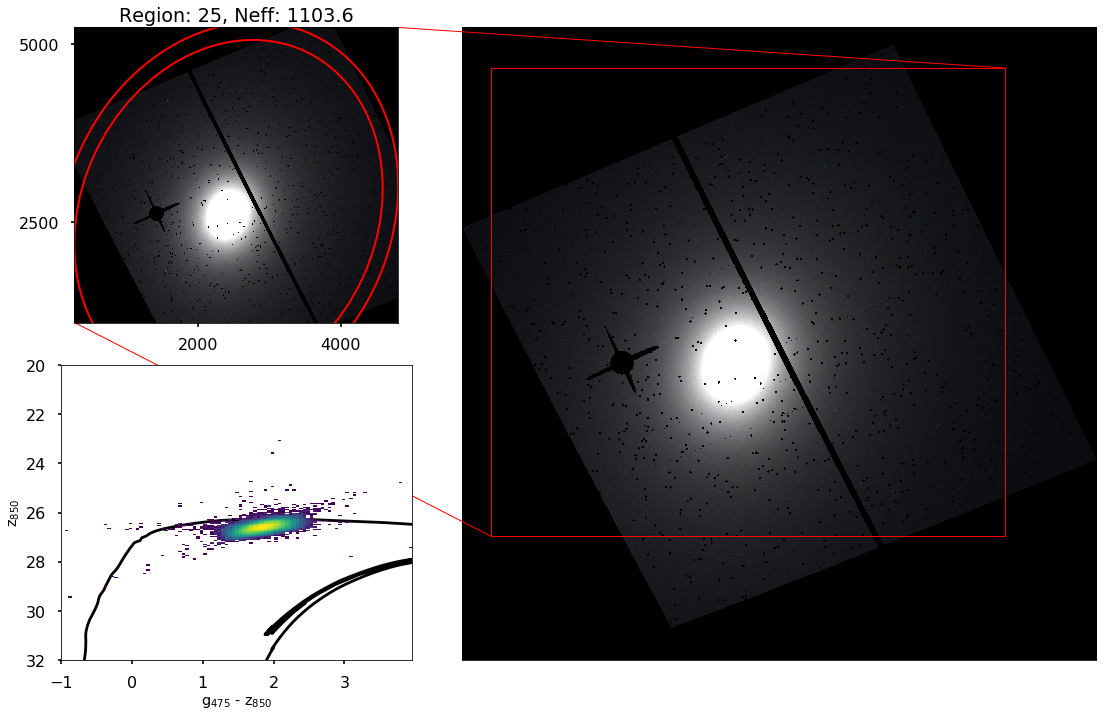

In [59]:
showcase_region(25)

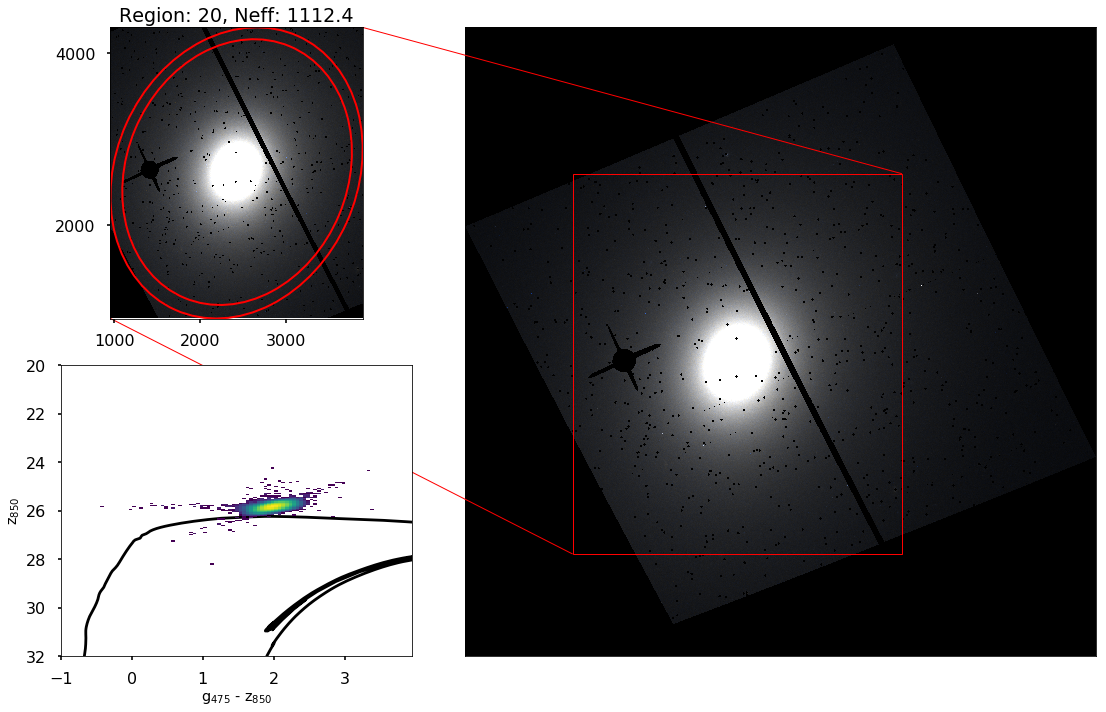

In [60]:
showcase_region(20)

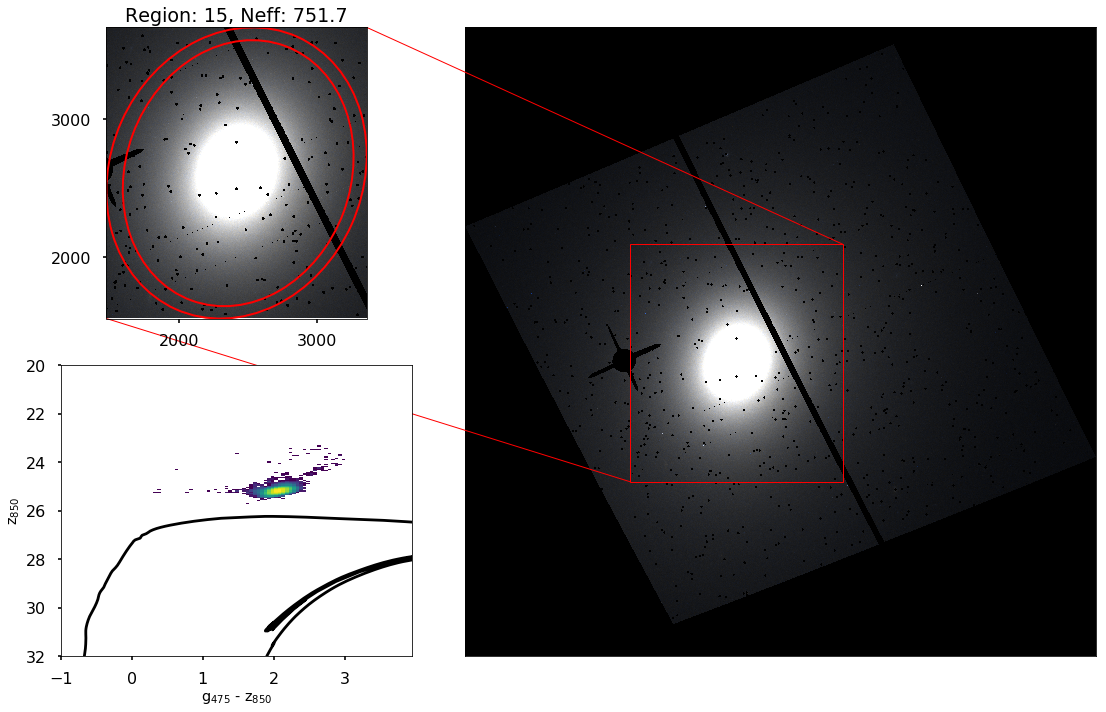

In [ ]:
showcase_region(15)

In [ ]:
showcase_region(10)

In [ ]:
showcase_region(5)

(28, 20)

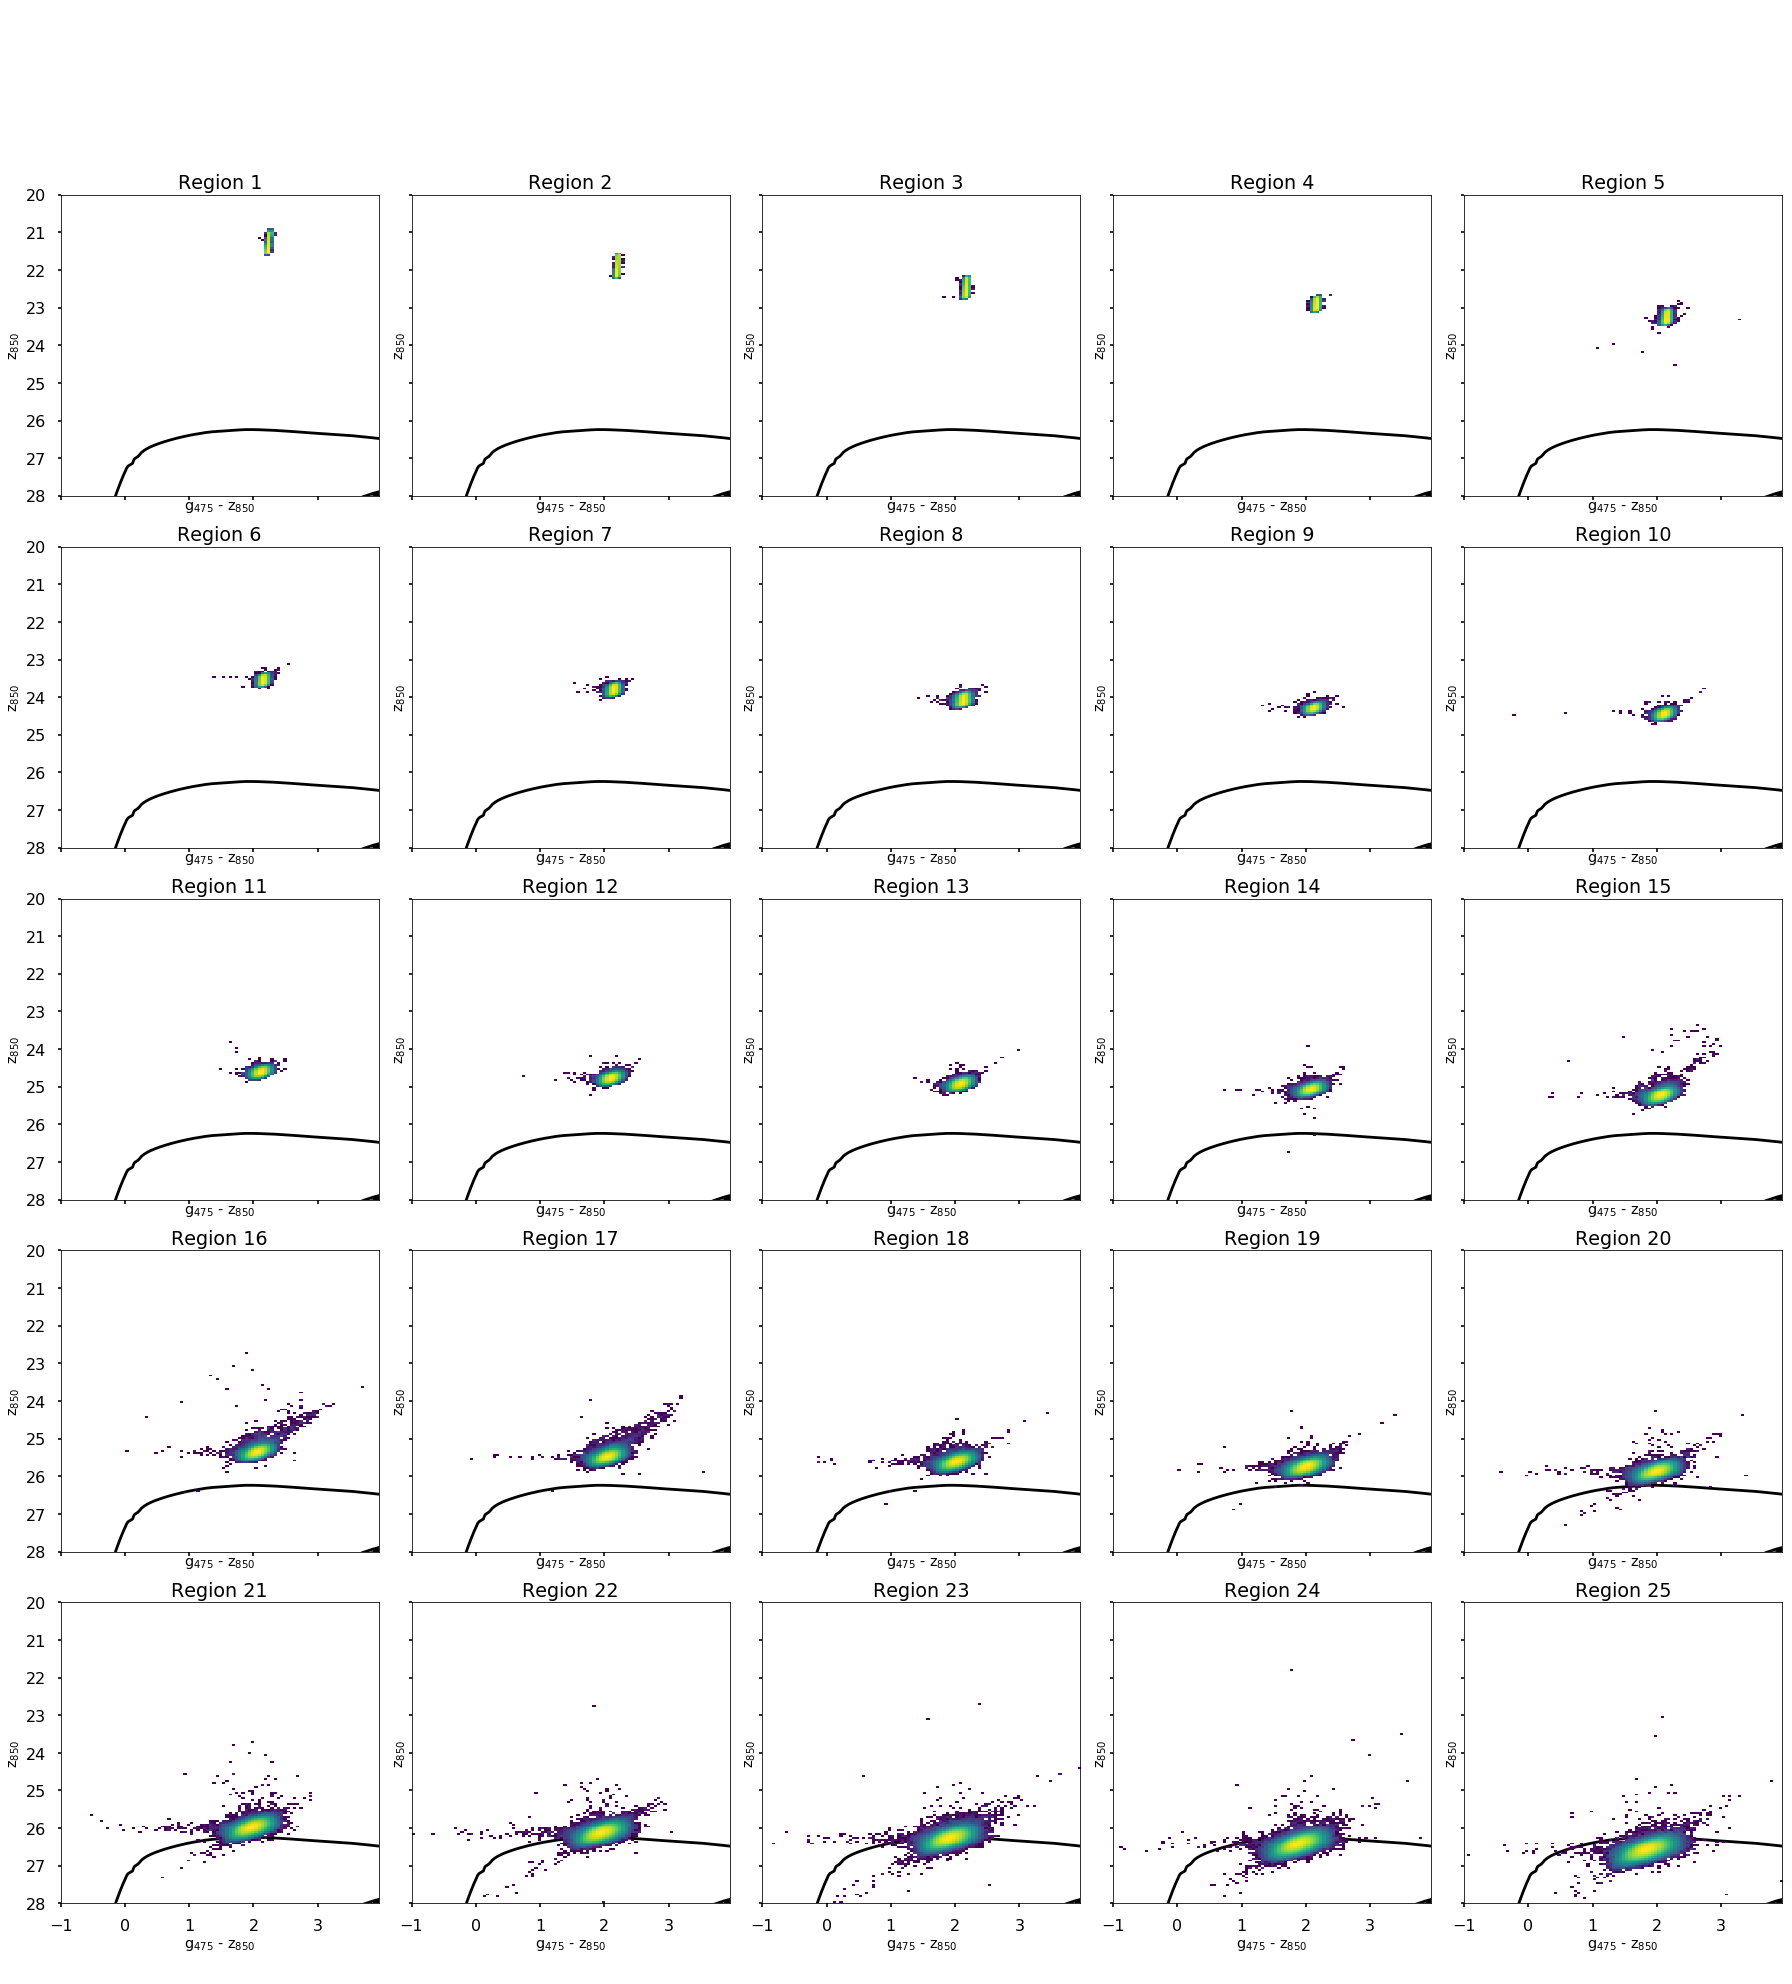

In [33]:
fig, axes = plt.subplots(ncols=5, nrows=5, figsize=(25, 25), sharex=True, sharey=True)
axes = axes.flatten()
for ax, k in zip(axes, list(pcmd_regions.keys())):
    ppy.plotting.plot_pcmd(m49_data.get_pcmd((ids_final == k)), bins=bins, axes=ax, title='Region {:d}'.format(k))
    ppy.plotting.plot_isochrone(iso_model, dmod=31.29, zorder=-1, axes=ax)
plt.tight_layout()
axes[0].set_ylim([28, 20])

In [83]:
def save_pcmd(k):
    this_mask = (ids_final == k)
    pcmd_data = m49_data.get_pcmd(this_mask)
    if k == 1:
        i_inner = 1
        sma_inner = 0.
    else:
        i_inner = pcmd_regions[k-1][-1]
        sma_inner = isolist_F850LP[i_inner].sma
    i_outer = pcmd_regions[k][-1]
    sma_outer = isolist_F850LP[i_outer].sma
    base_info = 'Vega Mags\n'
    base_info += 'Elliptical M49 region extracted from isophotes ({:d},{:d}]\n'.format(i_inner, i_outer)
    base_info += 'Semi-Minor Axes (pix): ({:.1f}, {:.1f}]\n'.format(sma_inner, sma_outer)
    base_info += 'Num Pixels: {:d}\nNeff ~ {:.0f}^2\n'.format(np.sum(this_mask), Neffs[k])
    base_info += 'zmag gmag-zmag\nF850LP F475W-F850LP\n'
    filename = '../data/m49_r{:d}_z-gz.dat'.format(k)
    np.savetxt(filename, pcmd_data.T, fmt='%.6f', header=base_info)
    print('saved to: {:s}'.format(filename))

In [84]:
for k in range(1, k_max):
    save_pcmd(k)

saved to: ../data/m49_r1_z-gz.dat
saved to: ../data/m49_r2_z-gz.dat
saved to: ../data/m49_r3_z-gz.dat
saved to: ../data/m49_r4_z-gz.dat
saved to: ../data/m49_r5_z-gz.dat
saved to: ../data/m49_r6_z-gz.dat
saved to: ../data/m49_r7_z-gz.dat
saved to: ../data/m49_r8_z-gz.dat
saved to: ../data/m49_r9_z-gz.dat
saved to: ../data/m49_r10_z-gz.dat
saved to: ../data/m49_r11_z-gz.dat
saved to: ../data/m49_r12_z-gz.dat
saved to: ../data/m49_r13_z-gz.dat
saved to: ../data/m49_r14_z-gz.dat
saved to: ../data/m49_r15_z-gz.dat
saved to: ../data/m49_r16_z-gz.dat
saved to: ../data/m49_r17_z-gz.dat
saved to: ../data/m49_r18_z-gz.dat
saved to: ../data/m49_r19_z-gz.dat
saved to: ../data/m49_r20_z-gz.dat
saved to: ../data/m49_r21_z-gz.dat
saved to: ../data/m49_r22_z-gz.dat
saved to: ../data/m49_r23_z-gz.dat
saved to: ../data/m49_r24_z-gz.dat
